In [1]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

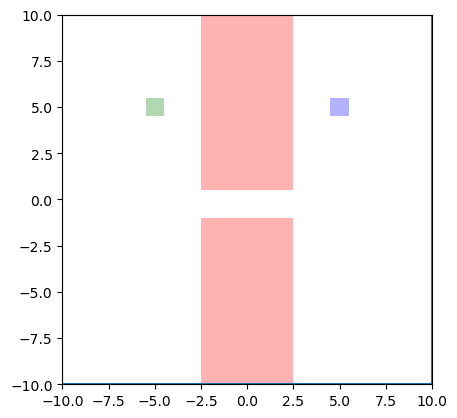

In [2]:

start_locs = np.array([[5,5]])
goal_locs = np.array([[-5,5]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

# The RRT algorithm: LaValle 1998

**Important primitive functions for RRT**

In [81]:
import shapely
from numpy import linalg as la
def uniform_rand_loc(env):
    return np.random.uniform(low = [env.limits[0][0],env.limits[1][0]],
                    high = [env.limits[0][1],env.limits[1][1]])


def in_env_boundary(env,x,bloating_r):
    return env.limits[0][0]+bloating_r<=x[0]<=env.limits[0][1]-bloating_r\
          and env.limits[1][0]+bloating_r<=x[1]<=env.limits[1][1]-bloating_r
    
def has_point_collision(env,x,bloating_r):
    '''
        Output: whether putting an agent with bloating radius=bloating_r at location x in env induces collision.
    '''
    if in_env_boundary(env,x,bloating_r):
        for o in env.obstacles:           
            if shapely.Point(x).distance(o.vertices())<bloating_r:
                return True
        return False
    else:
        Warning("The test location x={} is not within the limits of the environment.".format(x))
        return True 

def has_line_collision(env,x1,x2,bloating_r):
    '''
        Output: whether the bloated line segment x1-x2 with bloating radius = bloating_r intersects with any of the obstacles in env.
    '''
    if in_env_boundary(env,x1,bloating_r) and in_env_boundary(env,x2,bloating_r):
        l = shapely.LineString([x1,x2]) 
        for o in env.obstacles:
            if l.distance(o.vertices())<bloating_r:
                return True
        return False
    else:
        Warning("The test locations may not be within the limits of the environment.")
        return True 

def binary_line_search(env,x_start,x_target,bloating_r,eta = None,eps = 1e-5):
    '''
        A heuristic to decide a new 
        Output: min_x ||x-x_target|| such that 
               0) x lies on x_start-x_target
               1) has_line_collision(env,x_start,x,bloating_r) is False
               2) If eta is not None, then also ||x-x_start||<=eta. 
    '''
    
    
    if eta is not None:
        direction = x_target-x_start
        x_target = x_start + eta * direction/la.norm(direction)

    lo = 0
    hi = 1
    while hi-lo>eps:
        mid = (hi+lo)/2
        # print(hi,lo,mid)
        x_cur = x_start * (1-mid) + x_target * mid
        if has_line_collision(env,x_start,x_cur,bloating_r):
            # Shrink the line segment
            hi = mid
        else:
            # Expand the line segment
            lo = mid

    return x_cur

In [82]:

x_rand = np.array([9.6,2.0])
x_new = binary_line_search(env,start_locs[0],x_rand,bloating_r)

1 0 0.5
1 0.5 0.75
1 0.75 0.875
1 0.875 0.9375
1 0.9375 0.96875
1 0.96875 0.984375
0.984375 0.96875 0.9765625
0.984375 0.9765625 0.98046875
0.98046875 0.9765625 0.978515625
0.978515625 0.9765625 0.9775390625
0.978515625 0.9775390625 0.97802734375
0.978515625 0.97802734375 0.978271484375
0.978271484375 0.97802734375 0.9781494140625
0.978271484375 0.9781494140625 0.97821044921875
0.978271484375 0.97821044921875 0.978240966796875
0.978271484375 0.978240966796875 0.9782562255859375
0.978271484375 0.9782562255859375 0.9782638549804688


True


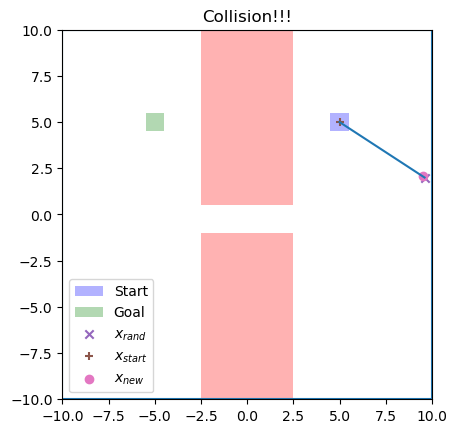

In [83]:
ax = plt.gca()
# x_rand = uniform_rand_loc(env)

# x_rand = [9.6,2.0]


# coll = has_collision(env,x_rand,bloating_r)
coll = has_line_collision(env,start_locs[0],x_rand,bloating_r)
draw_env(env,ax=ax)



ax.scatter(*x_rand,marker = 'x',label = r'$x_{rand}$')
ax.scatter(*start_locs[0],marker = "+",label = r'$x_{start}$')
ax.scatter(*x_new, marker = "o",label = r'$x_{new}$')
ax.plot([x_rand[0],start_locs[0][0]],[x_rand[1],start_locs[0][1]])


ax.set_title("Collision!!!" if coll else "No collision")
print(coll)
ax.legend()
plt.show()
